In [108]:
import numpy as np
import GPy
import matplotlib.pyplot as plt

from agent_utilities import *

import tikzplotlib

#set a specific seed for reproducibility of results


In [109]:
x1 = np.random.uniform(-1.5,1.5,100).reshape(-1,1)
x2 = np.random.uniform(-1.5,1.5,100).reshape(-1,1)
x3 = np.random.uniform(-1.5,1.5,100).reshape(-1,1)


y = np.sin(x1**3) + np.cos(x2**2) - np.sin(x3)



y1 = np.sin(x1**3).reshape(-1,1)
y2 = np.cos(x2**2).reshape(-1,1)
y3 = np.sin(x3).reshape(-1,1)

kern_g1 = GPy.kern.RBF(1)

kern_f1 = kern_g1.copy()
kern_g2 = kern_g1.copy()
kern_f2 = kern_g1.copy()
kern_g3 = kern_g1.copy()
kern_f3 = kern_g1.copy()
kern_test = kern_g1.copy()

test_model = GPy.models.GPRegression(y1,y,kern_test)
test_model.optimize()




***GP For Agent 1***

Max Global Reward Index 1: [2.88897426] Local Reward: [0.92912139]
Max Global Reward Index 2: [2.88897426] Local Reward: [0.99986454]
Max Global Reward Index 3: [2.88897426] Local Reward: [-0.96001904]


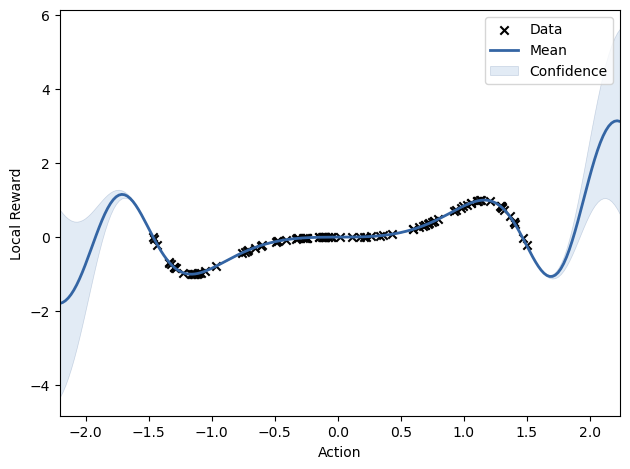

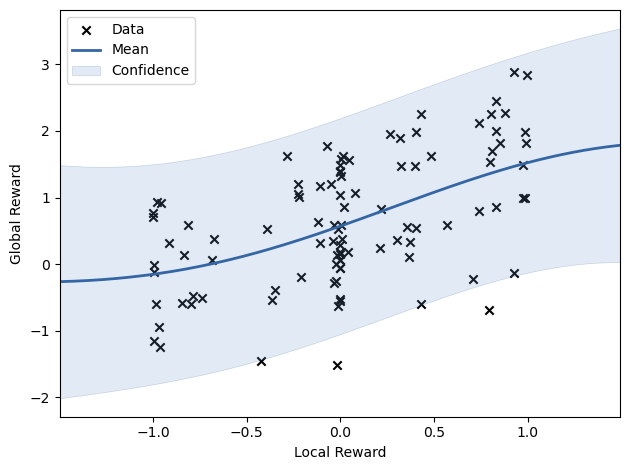

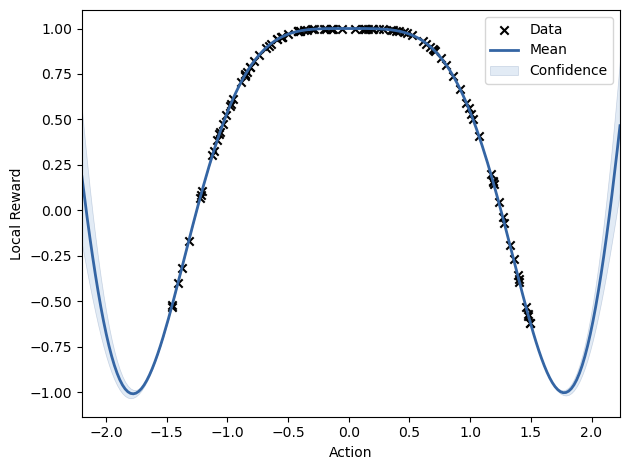

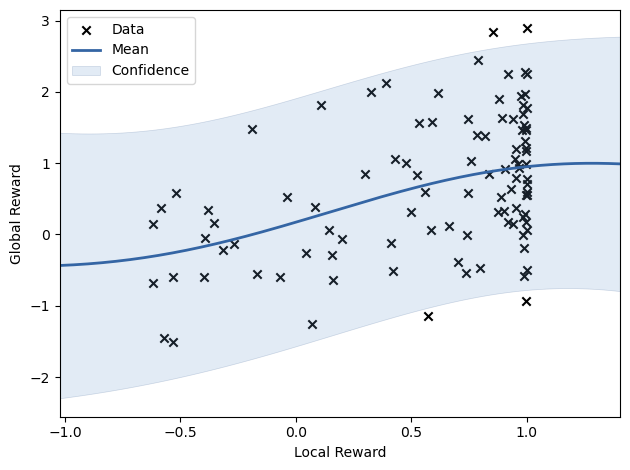

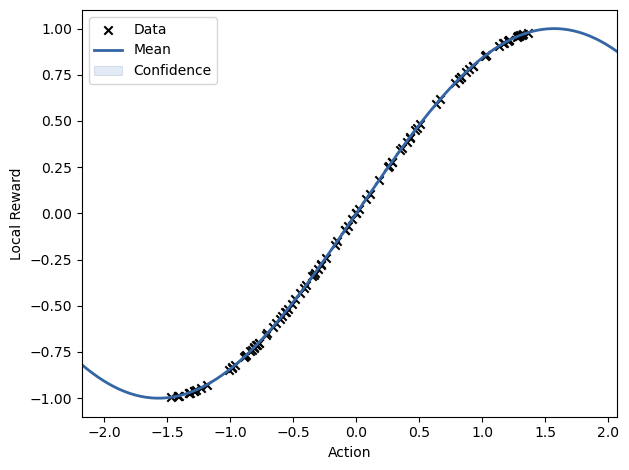

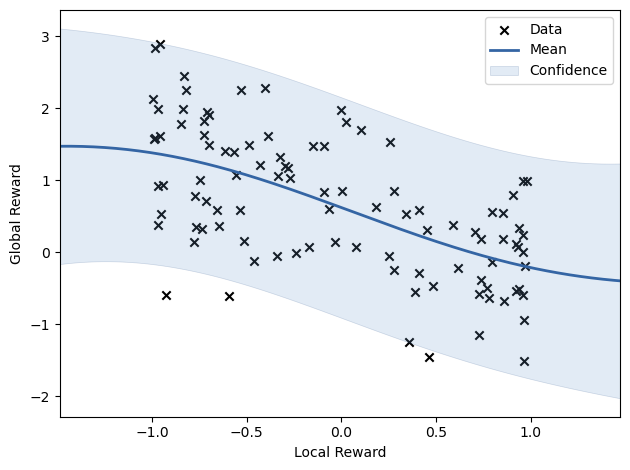

In [110]:
g1 = GPy.models.GPRegression(x1,y1,kern_g1)
g1.optimize()
g1_mean = g1.predict_noiseless(x1)[0]
g1.plot()
plt.xlabel('Action')
plt.ylabel('Local Reward')
tikzplotlib.save('g1.tex')

f1 =GPy.models.GPRegression(g1_mean,y,kern_f1)

f1.optimize()


max_y1 = max(f1.Y).astype(float)
max_x1 = f1.X[np.where(f1.Y == max_y1)]
max_coords = np.array([max_x1,max_y1])

print('Max Global Reward Index 1:',max_y1, 'Local Reward:', max_x1)

f1.plot()
plt.ylabel('Global Reward')
plt.xlabel('Local Reward')
# plt.scatter(max_x1,max_y1, color = 'red')
tikzplotlib.save('f1.tex')



g2 = GPy.models.GPRegression(x2,y2,kern_g2)
g2.optimize()

g2.plot()
plt.xlabel('Action')
plt.ylabel('Local Reward')

f2 =GPy.models.GPRegression(g2.predict_noiseless(x2)[0],y,kern_f2)
f2.optimize()


max_y2 = max(f2.Y).astype(float)
max_x2 = f2.X[np.where(f2.Y == max_y2)]
max_coords2 = np.array([max_x2,max_y2])

print('Max Global Reward Index 2:',max_y2, 'Local Reward:', max_x2)


f2.plot()
plt.ylabel('Global Reward')
plt.xlabel('Local Reward')
# plt.scatter(max_x2,max_y2, color = 'red')
tikzplotlib.save('f2.tex')

g3 = GPy.models.GPRegression(x3,y3,kern_g3)
g3.optimize()
g3.plot()

plt.xlabel('Action')
plt.ylabel('Local Reward')


f3 =GPy.models.GPRegression(g3.predict_noiseless(x3)[0],y,kern_f3)
f3.optimize()




max_y3 = max(f3.Y).astype(float)
max_x3 = f3.X[np.where(f3.Y == max_y3)]
max_coords3 = np.array([max_x3,max_y3])
print('Max Global Reward Index 3:',max_y3, 'Local Reward:', max_x3)



f3.plot()
plt.ylabel('Global Reward')
plt.xlabel('Local Reward')
# plt.scatter(max_x3,max_y3, color = 'red')
tikzplotlib.save('f3.tex')







In [111]:
class Agent_gp:
    def __init__(self,id,bounds,x0,argmax_coords,f,g):

        self.f = f
        self.g = g
        self.id = id
        self.bounds = [bounds]
        self.cords = argmax_coords
        self.x_max = argmax_coords[0]
        self.y_max = argmax_coords[1]



        self.action0_x = x0
        self.action0_y = self.f.Y[np.where(self.action0_x == self.f.X)].astype(float)

        print('Inital Local Reward Coords', self.action0_x, self.action0_y)
        print('Max Reward Coords:', self.x_max, self.y_max)

        self.dist0 = -np.abs(self.x_max - self.action0_x).reshape(-1,1)

        print('Initial Distance:', self.dist0)
    
        self.kern_opt = GPy.kern.RBF(1)
        self.parameter_space = safeopt.linearly_spaced_combinations(self.bounds, 100)

        self.gp_dist = GPy.models.GPRegression(np.asarray([[self.action0_x]]),self.dist0,self.kern_opt) # GP(local Reward, initial distance)
        self.safety = -np.inf
        print('Safety:', self.safety)
        self.opt_dist = safeopt.SafeOpt(self.gp_dist,self.parameter_space,self.safety,beta=0.5, threshold=1)
            

        # self.gp_dist = GPy.models.GPRegression(self.action0,self.dist0,self.kern_opt)


        
    def calculate_reward(self,x):

        if self.id == 1:
            
            return np.sin(x**3)


        elif self.id == 2:

            return np.cos(x**2)
            
        elif self.id == 3:

            return np.sin(x)        
        

    def predict_local(self):
        """predict the local reward using the SafeOpt model"""
        
        x_next = self.opt_dist.optimize()
        return x_next
    
    def update_local(self,x_next):
        """Update the local SafeOpt model by adding the local reward action and the distance"""

        y_mean = self.calculate_reward(x_next)
        self.y_dist = self.calculate_dist(y_mean)
        #log the information to the user
        print("Agent",self.id, "Local Reward:", y_mean)

        # self.y_dist = -(np.linalg.norm(self.y_dist)/np.linalg.norm(self.dist0))**2 #change 1
        #encourage positive performanc by avoiding same actions
        self.opt_dist.add_new_data_point(x_next,self.y_dist)
        
    
    def calculate_dist(self,y_local):
        """
        Calculate distance from local reward g(x) to the maximum local reward
        """
        self.dist  = -np.abs(self.x_max - y_local).reshape(-1,1)
        print("Agent",self.id, "Distance:", np.abs(self.dist))
        return self.dist
    
    def plot_initial(self):
        self.f.plot()

        plt.scatter(self.action0_x,self.action0_y ,color = 'red', label = 'Initial Reward')
        plt.scatter(self.x_max,self.y_max, color = 'green', label = 'Max Reward')
        
        

    def plot_local(self):
        self.g.plot()
        self.f.plot() 

    def plot_local_opt(self):
        self.opt_dist.plot(1000)

    

Inital Local Reward Coords -0.2240163431952169 [1.20692431]
Max Reward Coords: [0.92912139] [2.88897426]
Initial Distance: [[-1.15313773]]
Safety: -inf
Inital Local Reward Coords 0.19826927634312597 [-0.05643622]
Max Reward Coords: [0.99986454] [2.88897426]
Initial Distance: [[-0.80159526]]
Safety: -inf
Inital Local Reward Coords 0.278061332627658 [0.8528878]
Max Reward Coords: [-0.96001904] [2.88897426]
Initial Distance: [[-1.23808037]]
Safety: -inf


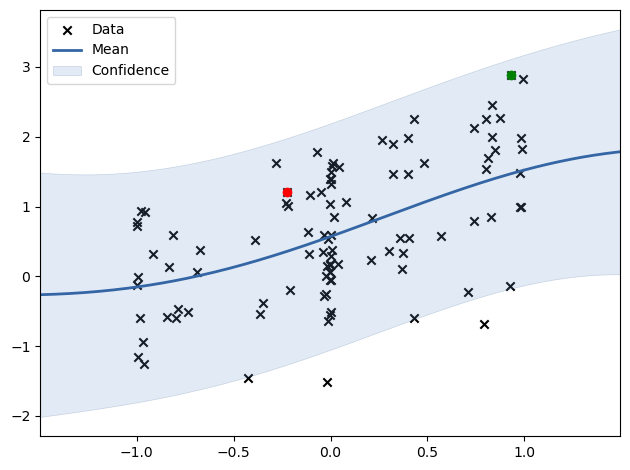

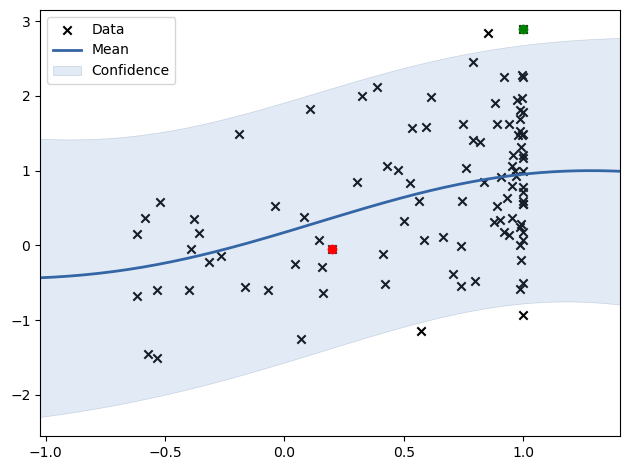

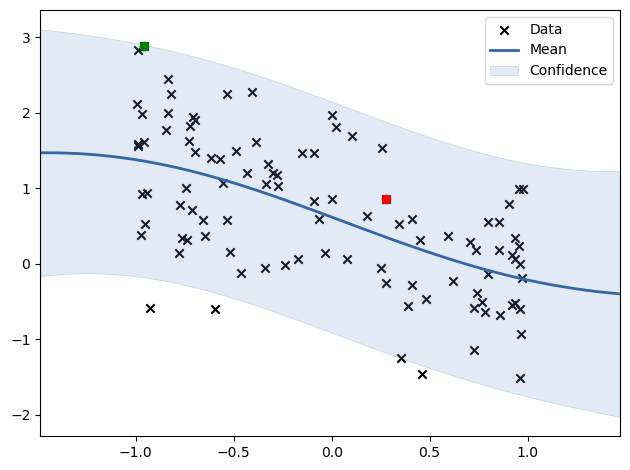

In [112]:
bounds = (np.min(x1),np.max(x1))
bounds = (-1.5,1.2)

# Define the specified range around 0
range_min, range_max = -0.3, 0.3

# Filter f1.X, f2.X, and f3.X to include only values within the specified range
filtered_x1 = f1.X.flatten()[(f1.X.flatten() >= range_min) & (f1.X.flatten() <= range_max)]
filtered_x2 = f2.X.flatten()[(f2.X.flatten() >= range_min) & (f2.X.flatten() <= range_max)]
filtered_x3 = f3.X.flatten()[(f3.X.flatten() >= range_min) & (f3.X.flatten() <= range_max)]

# Randomly select an element from each filtered subset if they are not empty
x01 = np.random.choice(filtered_x1) if len(filtered_x1) > 0 else None
x02 = np.random.choice(filtered_x2) if len(filtered_x2) > 0 else None
x03 = np.random.choice(filtered_x3) if len(filtered_x3) > 0 else None




agent1 = Agent_gp(1,bounds,x01,max_coords,f1,g1)
agent2 = Agent_gp(2,bounds,x02,max_coords2,f2,g2)
agent3 = Agent_gp(3,bounds,x03,max_coords3,f3,g3)

agent1.plot_initial()
agent2.plot_initial()
agent3.plot_initial()

agent_list = [agent1,agent2,agent3]



In [113]:
global_rewards = []

Predicted Next Action: [1.2] [-1.5] [-1.5]
Global Reward: [1.35699029]
Agent 1 Distance: [[0.05854754]]
Agent 1 Local Reward: [0.98766893]
Agent 2 Distance: [[1.62803816]]
Agent 2 Local Reward: [-0.62817362]
Agent 3 Distance: [[0.03747595]]
Agent 3 Local Reward: [-0.99749499]
Predicted Next Action: [-1.5] [1.2] [1.2]
Global Reward: [-0.57032156]
Agent 1 Distance: [[0.69782758]]
Agent 1 Local Reward: [0.23129381]
Agent 2 Distance: [[0.86944083]]
Agent 2 Local Reward: [0.13042371]
Agent 3 Distance: [[1.89205812]]
Agent 3 Local Reward: [0.93203909]
Predicted Next Action: [0.49090909] [-0.65454545] [-0.6]
Global Reward: [1.59229095]
Agent 1 Distance: [[0.81109213]]
Agent 1 Local Reward: [0.11802926]
Agent 2 Distance: [[0.09024532]]
Agent 2 Local Reward: [0.90961922]
Agent 3 Distance: [[0.39537656]]
Agent 3 Local Reward: [-0.56464247]
Predicted Next Action: [-1.5] [1.2] [-1.5]
Global Reward: [1.35921251]
Agent 1 Distance: [[0.69782758]]
Agent 1 Local Reward: [0.23129381]
Agent 2 Distance: [

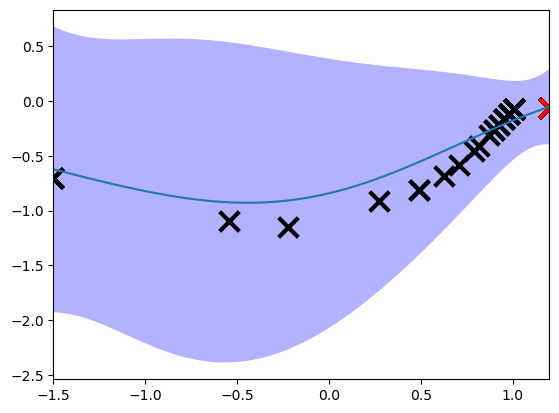

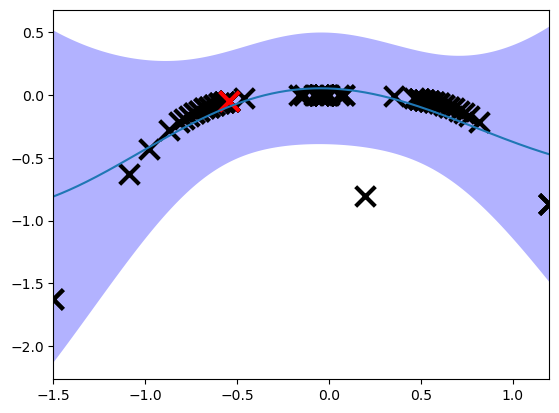

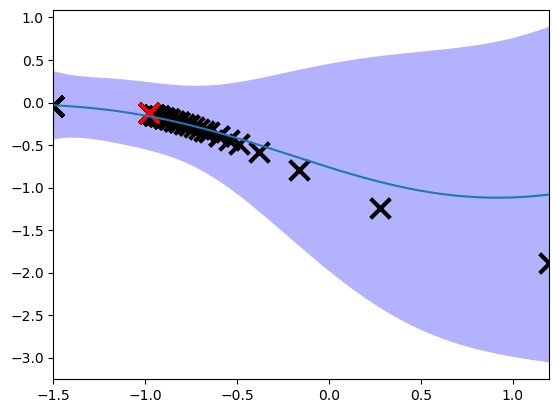

In [114]:
for i in range(100):

    x_next1 = agent1.predict_local()
    x_next2 = agent2.predict_local()
    x_next3 = agent3.predict_local()
    print('Predicted Next Action:',x_next1,x_next2,x_next3)

    global_reward = np.sin(x_next1**3) + np.cos(x_next2**2) - np.sin(x_next3)
    global_rewards.append(global_reward)
    print('Global Reward:', global_reward)

    agent1.update_local(x_next1)
    agent2.update_local(x_next2)
    agent3.update_local(x_next3)


agent1.plot_local_opt()
agent2.plot_local_opt()
agent3.plot_local_opt()



    

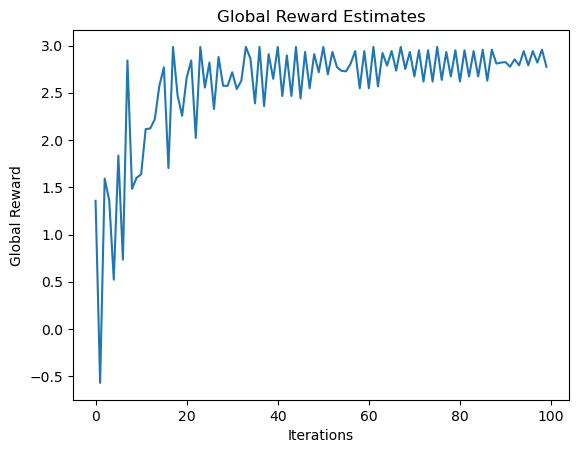

In [115]:
plt.plot((global_rewards))
plt.xlabel('Iterations')
plt.ylabel('Global Reward')
plt.title('Global Reward Estimates')
tikzplotlib.save('global_rewards.tex')


In [116]:
print('Global Reward:', max(global_rewards))
print('Initial Global Reward:', global_rewards[0])
print('Average Global Reward:', np.mean(global_rewards))

Global Reward: [2.98516392]
Initial Global Reward: [1.35699029]
Average Global Reward: 2.5691655130854203


In [117]:
print(agent1.opt_dist.get_maximum())
print(agent2.opt_dist.get_maximum())
print(agent3.opt_dist.get_maximum())




(array([1.2]), -0.10869703702720762)
(array([-0.05454545]), -0.019239559180827107)
(array([-1.5]), -0.09889101905682449)


In [118]:
print('Global Reward:', agent1.opt_dist.get_maximum())   
print('Global Reward:', agent2.opt_dist.get_maximum())
print('Global Reward:', agent3.opt_dist.get_maximum())



Global Reward: (array([1.2]), -0.10869703702720762)
Global Reward: (array([-0.05454545]), -0.019239559180827107)
Global Reward: (array([-1.5]), -0.09889101905682449)
